In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
from nltk.metrics import ConfusionMatrix
import numpy as np
import os, glob
import time
import itertools
from seaborn import heatmap
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
texts = []
table = str.maketrans('', '', '()؟«،»')
for filename in glob.glob('/content/drive/MyDrive/ANN/Datasets/Shahnameh/shahname/*.txt'):
    text = open(filename, 'rb').read().decode(encoding='utf-8')
    text = text.translate(table)
    text = text.replace('\t', ' / ').replace('\n', ' * ').replace("\u200c"," \u200c ")
    texts.append(text)

In [3]:
len_texts = np.array([len(text) for text in texts])
print(len_texts.min())
poems = [list(text[:len_texts.min()][::]) for text in texts]
seq_length = len_texts.min()-1

279


In [4]:
vocab = open("/content/drive/MyDrive/ANN/Datasets/Shahnameh/allShahnameWords.txt", 'rb').read().decode(encoding='utf-8')
words = vocab.translate(table)
words = list(words.replace('\t', ' / ').replace('\n', ' * ').replace('\u200c', ' \u200c ')[::])
words.append("*")
words.append("/")
words = list(set(words))
print(len(words))

42


In [5]:
ids_from_vocab = preprocessing.StringLookup(vocabulary=words, mask_token=None)
vocab_from_ids = preprocessing.StringLookup(vocabulary=ids_from_vocab.get_vocabulary(), invert=True, mask_token=None)

In [6]:
train, test = train_test_split(poems, train_size = 0.7, random_state=20)
val, test = train_test_split(test, train_size = 0.3, random_state=20)

In [7]:
train = ids_from_vocab(train)
val = ids_from_vocab(val)
test = ids_from_vocab(test)

In [8]:
xtrain = train[:,:-1]
ytrain = train[:,1:]
xval = val[:,:-1]
yval = val[:,1:]
xtest = test[:,:-1]
ytest = test[:,1:]

In [9]:
train_data = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_data = tf.data.Dataset.from_tensor_slices((xval,yval))

In [10]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000

train_data = (
    train_data
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

val_data = (
    val_data
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [11]:
vocab_size = len(words)
embedding_dim = 512
rnn_units = 512

In [12]:
tf.keras.backend.clear_session()

In [13]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=[None,None], return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states[0] is None:
      mStates, cStates = self.lstm.get_initial_state(x)
    else:
      mStates, cStates = states[0], states[1]
    x, mStates, cStates = self.lstm(x, initial_state=[mStates, cStates], training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, mStates, cStates
    else:
      return x


model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_vocab.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [14]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=loss, metrics=['accuracy'])

EPOCHS = 50
history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

Epoch 1/50
27/27 [==============================] - 4s 58ms/step - loss: 2.9578 - accuracy: 0.2425 - val_loss: 2.4009 - val_accuracy: 0.3364
Epoch 2/50
27/27 [==============================] - 1s 41ms/step - loss: 2.3015 - accuracy: 0.3461 - val_loss: 2.2068 - val_accuracy: 0.3636
Epoch 3/50
27/27 [==============================] - 1s 42ms/step - loss: 2.1570 - accuracy: 0.3750 - val_loss: 2.0930 - val_accuracy: 0.3859
Epoch 4/50
27/27 [==============================] - 1s 42ms/step - loss: 2.0565 - accuracy: 0.3983 - val_loss: 1.9996 - val_accuracy: 0.4133
Epoch 5/50
27/27 [==============================] - 1s 42ms/step - loss: 1.9722 - accuracy: 0.4203 - val_loss: 1.9333 - val_accuracy: 0.4336
Epoch 6/50
27/27 [==============================] - 1s 42ms/step - loss: 1.8953 - accuracy: 0.4425 - val_loss: 1.8508 - val_accuracy: 0.4548
Epoch 7/50
27/27 [==============================] - 1s 43ms/step - loss: 1.8224 - accuracy: 0.4645 - val_loss: 1.7889 - val_accuracy: 0.4715
Epoch 8/50
27

In [15]:
test_data = tf.data.Dataset.from_tensor_slices((xtest,ytest))

test_data = (
    test_data
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [16]:
model.evaluate(test_data)

8/8 [==============================] - 0s 17ms/step - loss: 1.5244 - accuracy: 0.5930


[1.524377465248108, 0.5929631590843201]

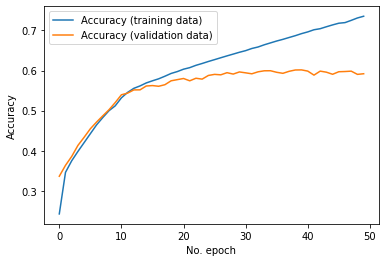

In [17]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='Accuracy (training data)')
plt.plot(val_accuracy, label='Accuracy (validation data)')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.show()

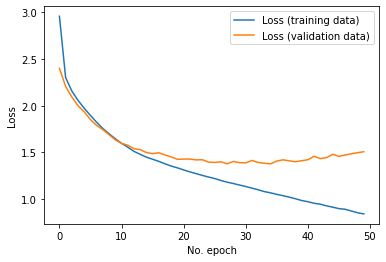

In [18]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='Loss (training data)')
plt.plot(val_loss, label='Loss (validation data)')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.show()

In [19]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=0.4):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=[None,None]):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    mStates, cStates = None, None
    predicted_logits, mStates, cStates = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, mStates,cStates

In [20]:
one_step_model = OneStep(model, vocab_from_ids, ids_from_vocab)
start = time.time()
mStates,cStates = None,None
next_char = tf.constant(['ی'])
result = [next_char]

for n in range(seq_length):
    next_char, mStates,cStates = one_step_model.generate_one_step(next_char, states=[mStates,cStates])
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8').replace('*', '\n').replace('/', '\t'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

یکی کوه بد ماه پر موبدان 	 که با من کام من گذشتی به راه 
 به فرزند شاهی برآمد ز جای 	 که با دانش و رای و برنا و تند 
 بران بارهٔ دژ پی ما بخواند 	 به دانش برآمد ز بالا بلند 
 سراپرده بر پای خاقانیان 	 به تخت از بر پای بر پای دید 
 بران بود ما را به درگاه شاه 	 ز بالا به دیدار تو 

________________________________________________________________________________

Run time: 1.187654972076416


In [21]:
def text_from_ids(ids):
  return tf.strings.reduce_join(vocab_from_ids(ids), axis=-1)

In [22]:
X_test_split = []
Y_test_split = []
for i in range(len(test)):
  text = text_from_ids(xtest[i])
  X_test_split.append(text.numpy().decode('utf-8'))
  text = text_from_ids(ytest[i])
  Y_test_split.append(text.numpy().decode('utf-8'))
print(X_test_split[0])

یکی نامور بود نامش سباک / ابا آلت و لشکر و رای پاک * که در شهر جهرم بد او پادشا / جهاندیده با داد و فرمانروا * مر او را خجسته پسر بود هفت / چو آگه شد از پیش بهمن برفت * ز جهرم بیامد سوی اردشیر / ابا لشکر و کوس و با دار و گیر * چو چشمش به روی سپهبد رسید / ز باره درآمد چنانچون سز


In [23]:
one_step_model = OneStep(model, vocab_from_ids, ids_from_vocab)
results = []
for ind in range(len(xtest)):
    mStates,cStates = None,None
    next_char = tf.constant([X_test_split[ind][0]])
    result = [next_char]

    for n in range(seq_length):
        next_char, mStates,cStates = one_step_model.generate_one_step(next_char, states=[mStates,cStates])
        result.append(next_char)

    result = tf.strings.join(result)
    result = result[0].numpy().decode('utf-8')
    results.append(result)
    if ind%50==0:
        print(X_test_split[ind][0] + Y_test_split[ind].replace("*", "\n").replace("/", "\t"), '\n' + '_'*80)
        print(result.replace("*", "\n").replace("/", "\t"), '\n\n' + '_.'*50)

یکی نامور بود نامش سباک 	 ابا آلت و لشکر و رای پاک 
 که در شهر جهرم بد او پادشا 	 جهاندیده با داد و فرمانروا 
 مر او را خجسته پسر بود هفت 	 چو آگه شد از پیش بهمن برفت 
 ز جهرم بیامد سوی اردشیر 	 ابا لشکر و کوس و با دار و گیر 
 چو چشمش به روی سپهبد رسید 	 ز باره درآمد چنانچون سزی 
________________________________________________________________________________
یکی نامه فرزند هرکس که بود 	 که با من نباشد پر از خون کنیم 
 به در به کار و به هر مهتری 	 جهاندار با من به بالان باد 
 از ایران بدو گفت با موبدان 	 به هر دو به مردی به دانش همال 
 بدو گفت با موبدان و ردان 	 که خواهران را بر میان اندر افراستان 
 بران باره ‌ ای برکشیدند شاه 	 به پ 

_._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._.
کنون پرشگفتی یکی داستان 	 بپیوندم از گفتهٔ باستان 
 نگه کن که مر سام را روزگار 	 چه بازی نمود ای پسر گوش دار 
 نبود ایچ فرزند مرسام را 	 دلش بود جویندهٔ کام را 
 نگاری بد اندر شبستان اوی 	 ز گلبرگ رخ داشت و ز مشک موی 
 از آن ماهش امید فرزند بود 	 که خورشی

In [24]:
bleu_scores = []
hypothesis_all = []
reference_all = []
for ind in range(len(results)):
    hypothesis = list(results[ind][1:][::])
    hypothesis_all = list(itertools.chain.from_iterable([hypothesis_all, hypothesis]))
    reference = list(Y_test_split[ind][::])
    reference_all = list(itertools.chain.from_iterable([reference_all, reference]))
    bleu_scores.append(sentence_bleu([reference], hypothesis, weights = [1]))

print(np.mean(bleu_scores))

0.8529540004360148


In [25]:
conf_mat = ConfusionMatrix(reference_all, hypothesis_all)

In [26]:
mat = np.zeros((len(words),len(words)))
for w1 in range(len(words)):
    for w2 in range(len(words)):
        try:
            mat[w1,w2] = conf_mat[words[w1],words[w2]]
        except:
            pass

In [27]:
conf = pd.DataFrame(mat, index=words,columns=words)

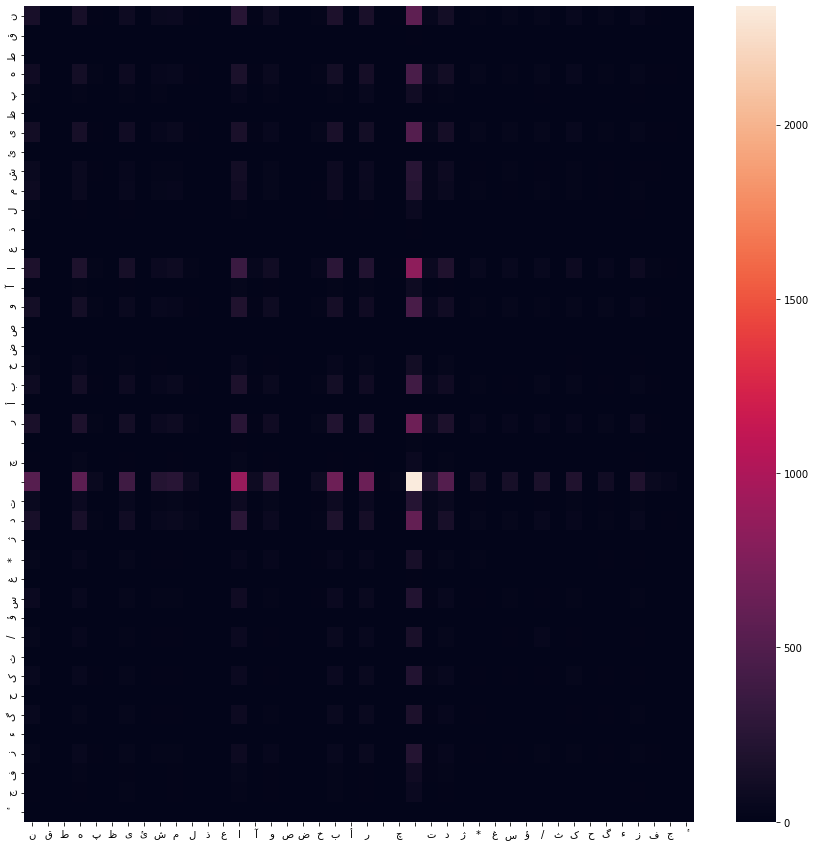

In [28]:
plt.figure(figsize=(15,15))
heatmap(conf)

In [29]:
print(np.sort(np.diag(conf))[-10:])
print([words[i] for i in np.argsort(np.diag(conf))[-10:]])

[32 15  6  3 19  0 26 21 13 24]
[  41.   90.  108.  122.  125.  147.  148.  219.  360. 2339.]
['/', 'و', 'ی', 'ه', 'ب', 'ن', 'د', 'ر', 'ا', ' ']


In [30]:
bleu_words_scores = []
for ind in range(len(results)):
    hypothesis = results[ind].split()[1:]
    reference = Y_test_split[ind].split()
    bleu_words_scores.append(sentence_bleu([reference], hypothesis, weights = [1]))

print(np.mean(bleu_words_scores))

0.27746652012740675
